# Exploratory Data Analysis (EDA)

In this section, we perform **Exploratory Data Analysis (EDA)** on the credit card fraud detection dataset. The goal of EDA is to gain an intuitive understanding of the dataset's structure, distribution, and key characteristics before proceeding with model development. This helps identify patterns, potential issues, and necessary preprocessing steps.

## 1. Dataset Overview

### 1.1 Source of Data

The dataset used in this study originates from a publicly available credit card fraud detection dataset on [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). It contains transactions made by European cardholders in **September 2013** over a **two-day period**.

### 1.2 Initial Description of the Data

- The dataset consists of **284,807** transactions, of which **492** are fraudulent.
- The dataset is **highly imbalanced**, as fraudulent transactions make up only **0.172%** of all transactions.
- Due to confidentiality reasons, the dataset only contains **numerical features** derived from **Principal Component Analysis (PCA)**.
- The original feature names are not disclosed. Instead, **28 principal components** are labeled as `V1, V2, ..., V28`.
- Two features were not transformed using PCA:
  - **Time**: Represents the number of seconds elapsed since the first transaction in the dataset.
  - **Amount**: Represents the transaction amount, which can be useful for cost-sensitive learning.
- The **target variable** (`Class`):
  - `0` → Legitimate transaction
  - `1` → Fraudulent transaction

### 1.3 Challenges and Limitations of the Dataset

Despite being widely used in research and benchmarking fraud detection models, the anonymized version of the dataset presents fundamental challenges that limit the depth of analysis and modeling techniques we can apply.

#### 1.3.1 Loss of Interpretability and Feature Engineering Constraints
- The dataset has been **anonymized** through **PCA transformation**, meaning the original transactional features are **unavailable**.
- **Domain-specific fraud detection techniques** often rely on **behavioral, relational, and statistical features**, but these **cannot be derived** due to PCA (see Section 1.4 for details).
- The lack of identifiable transaction attributes prevents **user-level profiling**, which is commonly used for fraud detection.

#### 1.3.2 Constraints on Data Augmentation
- **Data augmentation techniques**, such as **SMOTE, ADASYN, and synthetic sampling**, are commonly used to mitigate class imbalance. These methods will be applied in this project to generate additional synthetic fraud samples. However, their **effectiveness is significantly impacted** by the lack of access to the original feature space. Since the dataset has undergone **PCA transformation**, these techniques operate on **principal components rather than raw transactional features**.
- The absence of raw transaction details limits our ability to **generate realistic synthetic fraud examples** using traditional augmentation strategies.
- Given the dataset’s extreme **class imbalance**, alternative approaches must be considered to address the limited number of fraud cases.

Since many traditional fraud detection methodologies are inapplicable due to these constraints, our analysis will focus on **what remains feasible**, such as statistical insights, anomaly detection, and evaluating PCA-transformed feature relationships.

### 1.4 Typical Feature Engineering in Credit Card Fraud Detection (Not Possible in This Dataset)

In real-world credit card fraud detection, **feature engineering** plays a crucial role in identifying suspicious transactions. However, due to the **PCA transformation and anonymization**, we are unable to extract many **behavioral and relational features** that could enhance model performance.

#### 1.4.1 Time-Based Features
Fraudulent transactions often follow distinct temporal patterns. Without access to raw timestamps (other than `Time`), we **cannot** engineer:
- **Time between successive transactions** (e.g., rapid small transactions can indicate fraud).
- **Hour of transaction** (fraud occurs more often at certain times of day).
- **Daily/weekly spending trends** (e.g., unusually high spending on weekends).

#### 1.4.2 Transaction Behavior Features
Fraud detection models typically leverage **spending behavior patterns**, but PCA removes merchant and category details, preventing:
- **Transaction category profiling** (e.g., high spending at luxury stores vs. essentials).
- **User-based spending habits** (e.g., deviation from past transaction patterns).
- **Merchant-based fraud patterns** (some merchants have higher fraud rates).

#### 1.4.3 Relational & Graph-Based Features
Fraud detection is increasingly relying on **graph-based models**, which analyze the relationships between entities (users, merchants, cards). We **cannot** construct:
- **Transaction networks** (linking users, merchants, and devices).
- **Shared device/IP detection** (fraudsters often use the same device for multiple accounts).
- **Merchant-user link analysis** (detecting if the same fraudster appears at multiple merchants).

#### 1.4.4 Aggregation & Statistical Features
Aggregating past transaction data allows us to flag suspicious patterns, but PCA prevents:
- **Rolling statistics** (e.g., average transaction amount over past 6 hours, or past 7 days).
- **Deviation from user’s typical transaction size** (e.g., sudden large purchases).

Given these constraints, we will shift our focus to **alternative approaches**, such as statistical analysis, anomaly detection, and understanding PCA-derived features.

## 2. Objectives of EDA

Before building a fraud detection model, we will nonetheless explore the dataset through:
1. **Data structure analysis**: Understanding column distributions, missing values, and data types.
2. **Statistical summaries**: Checking descriptive statistics for transaction amounts and time.
3. **Class imbalance visualization**: Examining fraud vs. non-fraud transaction distribution.
4. **Feature correlations**: Investigating relationships between PCA-transformed features.
5. **Anomaly detection insights**: Identifying key patterns in fraudulent transactions.

Next, we will load the dataset and conduct an initial inspection to assess its structure, spot inconsistencies, and prepare for deeper analysis.


## **3. Important Remark: Proper EDA Methodology in Fraud Detection**
> 
> A common mistake in many Kaggle notebooks is **performing EDA on the entire dataset before splitting it into training and test sets**. This can lead to **data leakage**, unrealistic insights, and over-optimistic model performance.  
>  
> In real-world fraud detection, the **test set must remain completely unseen** to simulate real deployment conditions. Any insights drawn from the test set before modeling can **unintentionally leak information** into feature selection, preprocessing, and modeling decisions.  
>  
**Correct Approach:**  
> - **Step 1: Split the data first** into **training, validation, and test sets**.  
> - **Step 2: Perform all EDA strictly on the training set** to ensure feature engineering decisions reflect real-world conditions.  
> - **Step 3: Keep the validation and test sets untouched** until model evaluation.  
>  
**What Should NOT Be Done:**  
> - Performing **statistical analysis, visualizations, or feature selection** on the entire dataset before splitting.  
> - Looking at **test set distributions** during EDA, which can bias the model.  
> - Applying transformations based on the entire dataset and then training a model.  
>  
> In this project, we **first split the data during preprocessing into training (80%), validation (10%), and test (10%) sets ensuring stratified sampling to maintain fraud class proportions**. **We will only analyze the training set in our EDA** to maintain methodological rigor.  
>  
> This ensures that our fraud detection model is **evaluated in a realistic setting**, where test data remains unseen until the final model assessment.

## 4. Exploring The Dataset

Recall that we have previously used the Sprak/pySpark to preporcess the data. Below we load the training set (both features and targets). 

In [1]:
import pandas as pd

# Load data and convert to NumPy arrays
X_train = pd.read_csv("../preprocessing_creditcard_train_features_80.csv")
y_train = pd.read_csv("../preprocessing_creditcard_train_labels_80.csv")

As observed below, the training set contains **227,534 samples**, which accounts for **80% of the entire dataset**. Notably, **no features contain NULL values**, indicating that **preprocessing was likely performed by the dataset creators** before applying anonymization techniques.  

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Structure Checks
dataset_info = X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227534 entries, 0 to 227533
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227534 non-null  float64
 1   Amount  227534 non-null  float64
 2   V1      227534 non-null  float64
 3   V2      227534 non-null  float64
 4   V3      227534 non-null  float64
 5   V4      227534 non-null  float64
 6   V5      227534 non-null  float64
 7   V6      227534 non-null  float64
 8   V7      227534 non-null  float64
 9   V8      227534 non-null  float64
 10  V9      227534 non-null  float64
 11  V10     227534 non-null  float64
 12  V11     227534 non-null  float64
 13  V12     227534 non-null  float64
 14  V13     227534 non-null  float64
 15  V14     227534 non-null  float64
 16  V15     227534 non-null  float64
 17  V16     227534 non-null  float64
 18  V17     227534 non-null  float64
 19  V18     227534 non-null  float64
 20  V19     227534 non-null  float64
 21  V20     22

Additionally, all values are stored as **64-bit floating points (`float64`)**, which is often unnecessary for this dataset. In most cases, using **32-bit floating points (`float32`)** is sufficient and provides two key advantages:  

- **Reduced memory footprint**: Switching from `float64` to `float32` roughly **halves memory usage** for the numeric columns (though some overhead remains in the data structure), enabling **more efficient computation**.  
- **Faster data transfer**: Because **data transfer between system storage, RAM, and processors** is a major source of **energy consumption and heat**, using `float32` can **improve processing speed** and **lower power consumption**. This is especially important in **large-scale fraud detection pipelines** handling **millions of transactions daily**.  

Given these factors, **converting the dataset to `float32` is a worthwhile optimization** unless **precision-sensitive operations require `float64`**. The code snippet below **confirms that all feature values can be safely cast to `float32`**.  

In [3]:
import numpy as np

# Get the maximum representable value for a 32-bit float
max_float32 = np.finfo(np.float32).max

# Check if the largest value in the dataset is within the limits of float32
if X_train.max().max() < max_float32:
    print("yes we can cast values of each feature into float32")
else:
    print("no, at least there is one sample for which one feature exceeds the maximum allowed float32 in Python")

yes we can cast values of each feature into float32


When preprocessing the data, we applied **standardization** on features (**excluding the `Time` feature**, of course). This standardization is evident in the **mean and standard deviation** of the features, as seen in the summary statistics below.  

Although this notebook primarily utilizes **XGBoost** for machine learning modeling—**which does not require normalization or standardization**—our implementation is designed with **generalization and modularity** in mind. This ensures that users interested in experimenting with **different models, such as Random Forest**, can seamlessly integrate them into our framework.  

In anticipation of such future extensions, **we have standardized the data** while preporcessing it, to make it more adaptable for a broader range of machine learning algorithms.

In [16]:
X_train.describe()

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,227534.000000,227534.000000,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,...,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05
mean,94789.371698,3.151543,3.547499e-17,-1.748767e-18,2.658126e-16,4.546794e-17,9.693165e-17,5.296266e-17,2.473256e-17,3.228973e-17,...,-9.992954e-19,1.848696e-17,8.743835e-19,-3.997182e-17,-2.135994e-17,-3.653674e-18,-1.928640e-16,-3.584972e-17,-7.494715e-19,-1.676943e-17
std,47490.918437,1.657186,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,-2.894962e+01,-4.432383e+01,-3.200527e+01,-3.937015e+00,-8.301713e+01,-1.969245e+01,-3.552906e+01,-6.202879e+01,...,-8.875562e+00,-7.032252e+01,-4.792230e+01,-1.509749e+01,-7.132063e+01,-4.682935e+00,-1.974990e+01,-5.253216e+00,-5.660346e+01,-4.614396e+01
25%,54183.000000,1.874874,-4.739133e-01,-3.634866e-01,-5.913218e-01,-5.994698e-01,-5.045635e-01,-5.777242e-01,-4.529201e-01,-1.757824e-01,...,-5.607919e-01,-2.722495e-01,-3.136122e-01,-7.485569e-01,-2.582310e-01,-5.847512e-01,-6.090893e-01,-6.784808e-01,-1.806620e-01,-1.616309e-01
50%,84669.500000,3.135494,8.460652e-03,4.095589e-02,1.180977e-01,-1.297121e-02,-4.079992e-02,-2.060892e-01,3.161333e-02,1.998252e-02,...,4.632713e-03,-8.002500e-02,-4.030320e-02,9.555043e-03,-1.905081e-02,6.828987e-02,3.066809e-02,-1.074474e-01,1.151786e-04,2.941035e-02
75%,139276.000000,4.357350,6.724203e-01,4.906323e-01,6.791783e-01,5.259322e-01,4.453194e-01,2.982171e-01,4.637411e-01,2.764336e-01,...,5.629007e-01,1.722386e-01,2.564401e-01,7.293001e-01,2.345120e-01,7.267830e-01,6.730041e-01,4.994487e-01,2.251462e-01,2.300980e-01
max,172792.000000,10.153941,1.256209e+00,1.344848e+01,6.214034e+00,1.184410e+01,2.539883e+01,5.518179e+01,9.835935e+01,1.695102e+01,...,6.881497e+00,5.086899e+01,3.742852e+01,1.450433e+01,3.585661e+01,7.569489e+00,1.442238e+01,7.075134e+00,7.928650e+01,1.012087e+02


## Outliers And Skewness

The function below allows us to modularly visualize box-plot for a list of features. To avoid repetition and diversions, we focus the discussion only one of the features, namely `V1`. The earlier box plot for `V1` suggested **asymmetry and a large number of extreme values in the negative direction**. However, to determine whether these values are meaningful in the context of fraud detection, we now examine the **distribution of `V1` separately for fraudulent (`Class = 1`) and non-fraudulent (`Class = 0`) transactions**.  

#### **Key Observations from the Box Plot**  
- If fraudulent transactions show a **systematic difference** in `V1` values compared to non-fraudulent ones, this may indicate that `V1` is an **important feature for distinguishing fraud**.  
- If both classes have **similar distributions**, then the observed extreme values in the overall box plot were likely **not specifically linked to fraud**.  

#### **Next Steps for Investigation**  
1. **Quantifying Skewness**  
   - The earlier observation suggested that `V1` might be **negatively skewed**, meaning that its distribution has a longer tail in the negative direction.  
   - Instead of relying on visual inspection alone, we will compute the **skewness score** for `V1` to confirm whether the distribution is statistically skewed.  

2. **Assessing Statistical Significance**  
   - If we observe meaningful differences between fraud and non-fraud transactions in `V1`, we can apply a **statistical test** (e.g., t-test) to determine whether these differences are statistically significant.  

So our next step is to formally **test the skewness of `V1`**, which will help validate whether the observed asymmetry is a real pattern in the data or just an artifact of PCA transformation.

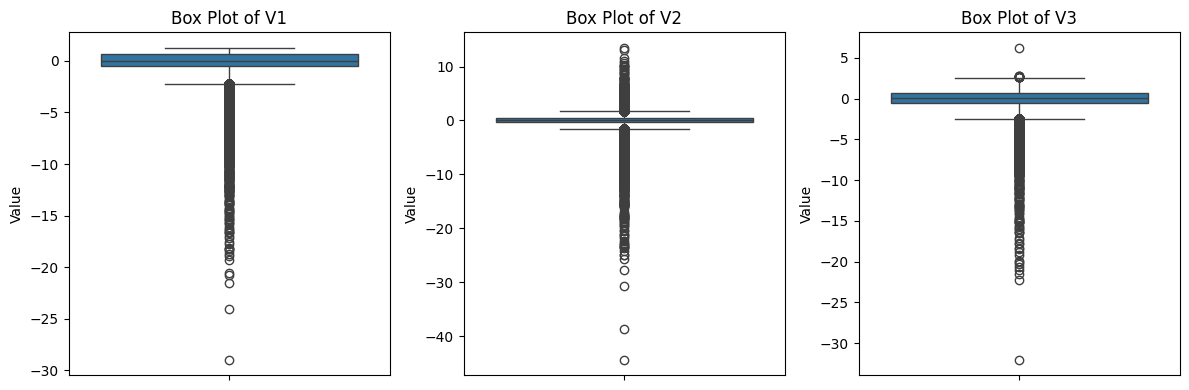

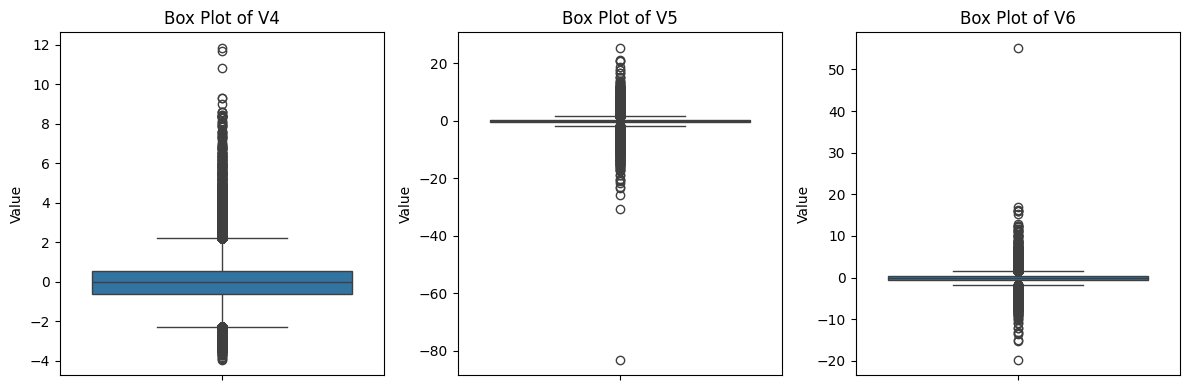

In [5]:
def plot_multiple_boxplots(feature_list, data):
    """
    Plots box plots for multiple features in the dataset.
    
    Parameters:
    - feature_list (list): List of feature names to plot.
    - data (DataFrame): The dataset (assumed to be X_train).
    
    Excludes 'Time' and 'Amount' from consideration.
    Displays plots in groups of three features at a time.
    """
    # Filter out excluded features
    valid_features = [f for f in feature_list if f not in ["Time", "Amount"] and f in data.columns]

    if not valid_features:
        print("No valid features to plot.")
        return

    # Plot in batches of three
    for i in range(0, len(valid_features), 3):
        batch = valid_features[i:i+3]
        num_plots = len(batch)

        plt.figure(figsize=(4 * num_plots, 4))
        
        for j, feature in enumerate(batch, 1):
            plt.subplot(1, num_plots, j)
            sns.boxplot(y=data[feature])
            plt.title(f"Box Plot of {feature}")
            plt.ylabel("Value")
        
        plt.tight_layout()
        plt.show()

feature_subset = ["V1", "V2", "V3", "V4", "V5", "V6"]  # Replace with the desired feature names
plot_multiple_boxplots(feature_subset, X_train)

### Checking Skewness of V1  

Before drawing conclusions about the asymmetry observed in `V1`, we must **formally test for skewness**.  

#### Why Check for Skewness?  
- **Visual inspection is not enough**—while the box plot showed an extended lower whisker, we need a numerical measure to confirm whether the distribution is **statistically skewed**.  
- **Skewness quantifies asymmetry**—a negative skewness score indicates a **longer tail on the left (negative side)**, while a positive score suggests a **longer right tail**.  

#### Steps for Skewness Testing 
1. **Compute the skewness score** for `V1`.  
2. **Interpret the result**:  
   - If **skewness < -1**, the distribution is **highly negatively skewed**.  
   - If **-1 < skewness < -0.5**, the distribution is **moderately negatively skewed**.  
   - If **-0.5 < skewness < 0.5**, the distribution is **approximately symmetric**.  

3. **Implications for Fraud Detection**  
   - If `V1` is **highly skewed**, we may need to consider **transformations** (e.g., log transformation) or handle outliers differently.  
   - If the skewness score is negligible, the earlier box plot observations might have **overstated the visual asymmetry**.  

Once the skewness test is completed, we will determine whether further adjustments are necessary for `V1` in fraud detection modeling.


In [6]:
# Re-import necessary libraries since execution state was reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, ttest_ind

# Function to check skewness
def check_feature_skewness(feature_name, data):
    """
    Computes the skewness of a given feature in the dataset.

    Parameters:
    - feature_name (str): The name of the feature to analyze.
    - data (DataFrame): The dataset (assumed to be X_train).

    Returns:
    - Skewness score (float)
    """
    if feature_name not in data.columns:
        print(f"Feature '{feature_name}' not found in dataset.")
        return None

    skewness_score = skew(data[feature_name])
    print(f"Skewness of '{feature_name}': {skewness_score:.4f}")

    return skewness_score

In [7]:
check_feature_skewness("V1", X_train)

Skewness of 'V1': -3.2706


np.float64(-3.270620148402151)

## **Should We Apply Log Transformation to V1? A Discussion Based on Model Choice**  
  
The **skewness score of `V1` is -3.2706** as the above computation shows. This indicates **high negative skewness**. Log transformation is often used to:  

- **Reduce skewness**: A heavily skewed feature can introduce biases in models that assume normally distributed data.  
- **Stabilize variance**: Log transformation compresses large values and spreads out small values, making distributions more balanced.  
- **Improve interpretability**: In some domains, log-transformed values may align better with real-world relationships (e.g., financial transactions).  

However, applying log transformation is not always necessary, and **the decision depends on the type of model being used**.  

### **Model Considerations: When Do We Need Log Transformation?**  
The necessity of applying a log transformation depends on whether the model being used **assumes linearity, distance-based relationships, or is robust to skewed features**.  

#### **Case 1: Distance-Based & Linear Models (Log Transformation Recommended)**  
**Examples**:  
- **Logistic Regression**  
- **SVM (Support Vector Machines)**  
- **k-Nearest Neighbors (k-NN)**  
- **One-Class SVM (for anomaly detection)**  

**Why Log Transformation Helps:**  
- Many of these models assume **linearly separable data**. Extreme values in a skewed feature like `V1` could cause **poor decision boundaries**.  
- Distance-based models (e.g., **k-NN, SVM**) rely on **Euclidean distance**. Skewed distributions can distort distances, leading to incorrect similarity measures.  
- **Logistic regression assumes a linear relationship** between predictors and the log-odds of fraud. A heavily skewed feature could **violate this assumption**, leading to unstable coefficients.  

**Recommendation**: If using one of these models, **log transformation (or another transformation like Box-Cox) should be strongly considered** to correct for skewness and improve model performance.  

#### **Case 2: Tree-Based Models (Log Transformation Not Required)**  
**Examples**:  
- **Decision Trees**  
- **Random Forest**  
- **XGBoost**  
- **Gradient Boosting Machines (GBM)**  

**Why Log Transformation is Unnecessary:**  
- Tree-based models **do not assume any specific feature distribution**.  
- They are **robust to skewed data** because they split based on feature thresholds rather than distance metrics.  
- Transforming the data might **not improve performance**, and in some cases, could even reduce interpretability.  

**Recommendation**: If the primary model is **XGBoost or another tree-based method**, **log transformation is likely unnecessary**.  


### **Practical Decision: Should We Log Transform `V1`?**  
Since we are considering **XGBoost as our main model**, applying log transformation to `V1` **is not strictly necessary**. However, if we intend to experiment with **logistic regression or distance-based anomaly detection models (e.g., One-Class SVM)**, then **log transformation should be applied to correct for extreme skewness**.  

### **Generalizing This Decision to Other Features**  
- We should check **skewness for all PCA-transformed features** and follow the same model-based approach.  
- If a feature is **highly skewed**, we only apply transformation **if needed** for the chosen model.  
- Tree-based models will **not require transformations**, whereas **logistic regression or distance-based models might benefit from them**.  

### **Next Steps**  
**Check the skewness of all PCA features** and identify which ones are highly skewed.  
**Decide which models we plan to use beyond XGBoost** (if we experiment with logistic regression, we apply log transformation accordingly).  
**If log transformation is applied**, compare model performance **with and without it** to measure its impact. 

We leave the investigations of the next steps out of this notebook to avoid repetition; they can be carried out in a similar manner to the `V1` case.

## Statistically Measuring Difference Between Fraud and Non-fraud samples along `V1`

In [12]:
# Function to compare feature distribution between fraud and non-fraud cases
def compare_feature_distribution(feature_name, data):
    """
    Compares the distribution of a feature for fraud and non-fraud cases.

    Parameters:
    - feature_name (str): The feature to analyze.
    - data (DataFrame): The dataset (assumed to be X_train).

    Returns:
    - t-test p-value (float) indicating whether the mean difference is statistically significant.
    - Box plot comparing fraud vs. non-fraud cases.
    """
    if feature_name not in data.columns:
        print(f"Feature '{feature_name}' not found in dataset.")
        return None

    fraud_values = data[y_train["Class"] == 1][feature_name]
    non_fraud_values = data[y_train["Class"] == 0][feature_name]

    # Perform independent t-test
    t_stat, p_value = ttest_ind(fraud_values, non_fraud_values, equal_var=False)  # Welch's t-test

    print(f"T-test for '{feature_name}':")
    print(f"  - T-statistic: {t_stat:.4f}")
    print(f"  - P-value: {p_value:.6f}")
    
    # Visualizing box plot
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=y_train["Class"], y=X_train[feature_name])
    plt.title(f"Box Plot of {feature_name} by Fraud Label")
    plt.xlabel("Fraud Label (0 = Non-Fraud, 1 = Fraud)")
    plt.ylabel(feature_name)
    plt.show()

    return p_value

T-test for 'V1':
  - T-statistic: -13.0261
  - P-value: 0.000000


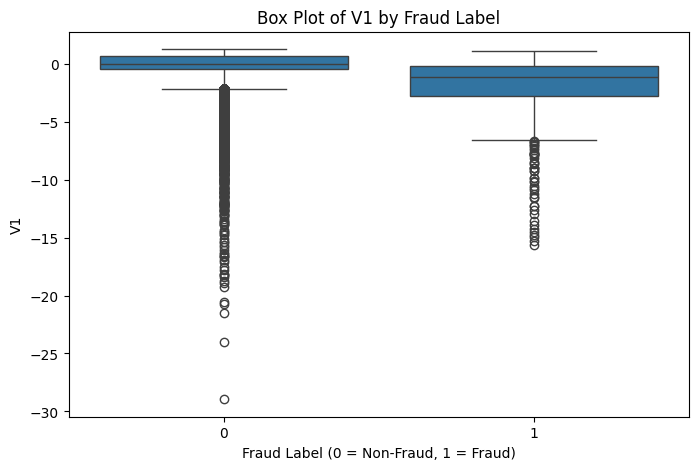

np.float64(4.4680612035513273e-32)

In [13]:
compare_feature_distribution("V1", X_train)

In [22]:
from scipy.stats import ttest_ind

def compare_feature_distribution(feature_name, data):
    """
    Compares the distribution of a feature for fraud and non-fraud cases.

    Parameters:
    - feature_name (str): The feature to analyze.
    - data (DataFrame): The dataset (assumed to be X_train).

    Returns:
    - t-test p-value (float) indicating whether the mean difference is statistically significant.
    - Side-by-side box plots comparing fraud vs. non-fraud cases.
    """
    if feature_name not in data.columns:
        print(f"Feature '{feature_name}' not found in dataset.")
        return None

    fraud_values = data[y_train["Class"] == 1][feature_name]
    non_fraud_values = data[y_train["Class"] == 0][feature_name]

    # Perform independent t-test
    t_stat, p_value = ttest_ind(fraud_values, non_fraud_values, equal_var=False)  # Welch's t-test

    print(f"T-test for '{feature_name}':")
    print(f"  - T-statistic: {t_stat:.4f}")
    print(f"  - P-value: {p_value:.6f}")

    # Side-by-side box plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.boxplot(y=non_fraud_values, ax=axes[0])
    axes[0].set_title(f"Non-Fraud Cases (Class = 0)\n{feature_name}")
    axes[0].set_ylabel(feature_name)

    sns.boxplot(y=fraud_values, ax=axes[1])
    axes[1].set_title(f"Fraud Cases (Class = 1)\n{feature_name}")
    axes[1].set_ylabel(feature_name)

    plt.tight_layout()
    plt.show()

    return p_value

T-test for 'V1':
  - T-statistic: -13.0261
  - P-value: 0.000000


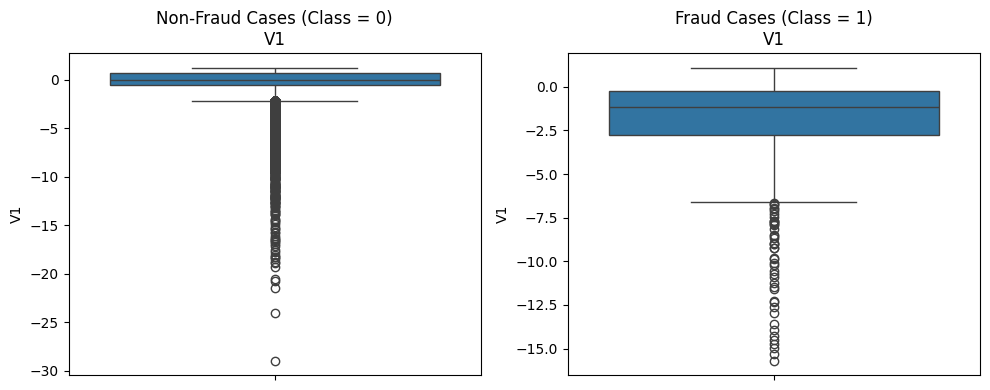

np.float64(4.4680612035513273e-32)

In [23]:
compare_feature_distribution("V1", X_train)  # Run this with the dataset to check fraud vs. non-fraud differences

## **Interpreting the T-test Results for V1**  
The **t-test for `V1`** resulted in:  
- **T-statistic**: `-13.0261`  
- **P-value**: `4.4680612035513273e-32` (effectively **zero**)  

Since the **p-value is extremely small (< 0.05)**, this suggests that **there is a statistically significant difference** between the mean values of `V1` for **fraudulent vs. non-fraudulent** transactions.  

## Why Use Welch’s T-test? 
We specifically used **Welch’s t-test** instead of the standard **Student’s t-test** because:  

- **Assumption of Unequal Variances**  
   - Welch’s t-test **does not assume equal variance** between the two groups (fraud vs. non-fraud).  
   - Given that fraud cases are **highly imbalanced** (only 0.172% of transactions), their variance may be different from non-fraud cases.  
   - Welch’s t-test corrects for this by **adjusting the degrees of freedom** accordingly.  

- **More Robust for Unequal Sample Sizes**  
   - The fraud dataset is **much smaller** than the non-fraud dataset (only 492 fraud cases vs. 284,315 non-fraud cases).  
   - The standard **Student’s t-test assumes equal sample sizes**, which is **not true in our case**.  
   - Welch’s t-test is **more reliable** when one group is much smaller than the other.  

## Statistical Significance vs. Practical Significance 
It should come as **no surprise** that `V1` is **statistically significant**, simply because it is a **principal component** of the PCA transformation applied by the dataset creators to anonymize the data. Since PCA selects components that **maximize variance**, it naturally ensures that `V1` captures meaningful differences in the transformed space.  

However, **statistical significance does not necessarily imply practical significance** for fraud detection. A next step to assess its **real-world importance** is:  
- **Feature Importance Analysis**: Using **tree-based models (e.g., XGBoost, Random Forest)** to see if `V1` contributes meaningfully to model performance.  
- **SHAP Analysis**: Applying **SHAP (SHapley Additive exPlanations)** to measure the **actual impact of `V1` on fraud prediction**.  

These steps will allow us to **validate whether `V1` is just statistically different or also practically useful** for fraud detection modeling.  

## Next Steps 
**Compute the effect size (Cohen’s D)** to measure the magnitude of the difference.  
**Analyze feature importance and SHAP values later** to determine if `V1` is practically useful for ML models.  

In [24]:
defccompute_cohens_d(feature_name, data):
    """
    Computes Cohen's D effect size for a given feature between fraud and non-fraud cases.

    Parameters:
    - feature_name (str): The feature to analyze.
    - data (DataFrame): The dataset (assumed to be X_train).

    Returns:
    - Cohen's D effect size (float) indicating the magnitude of difference between the two groups.
    """
    if feature_name not in data.columns:
        print(f"Feature '{feature_name}' not found in dataset.")
        return None

    fraud_values = data[y_train["Class"] == 1][feature_name]
    non_fraud_values = data[y_train["Class"] == 0][feature_name]

    # Compute means and standard deviations
    mean_fraud = np.mean(fraud_values)
    mean_non_fraud = np.mean(non_fraud_values)
    std_fraud = np.std(fraud_values, ddof=1)  # Sample standard deviation (unbiased estimate)
    std_non_fraud = np.std(non_fraud_values, ddof=1)

    # Compute pooled standard deviation
    pooled_std = np.sqrt(((len(fraud_values) - 1) * std_fraud**2 + (len(non_fraud_values) - 1) * std_non_fraud**2) /
                          (len(fraud_values) + len(non_fraud_values) - 2))

    # Compute Cohen's D
    cohens_d = (mean_fraud - mean_non_fraud) / pooled_std

    print(f"Cohen's D for '{feature_name}': {cohens_d:.4f}")
    return cohens_d

In [25]:
# choose any feature other than V1 if you desire

compute_cohens_d("V1", X_train)

Cohen's D for 'V1': -2.3583


np.float64(-2.358301263933757)

## Understanding Cohen’s D and Its Meaning for V1 

Cohen’s D is a **measure of effect size**, quantifying the **standardized difference between two groups**. Unlike a t-test, which only determines if a difference is statistically significant, Cohen’s D measures **how large the difference is** in practical terms.  

- **Small effect** → `0.2 ≤ d < 0.5`  
- **Medium effect** → `0.5 ≤ d < 0.8`  
- **Large effect** → `d ≥ 0.8`  

A **negative value** simply means that the fraud group has a lower mean than the non-fraud group.

### Interpretation for V1 
For `V1`, we obtained:  
- **Cohen’s D = -2.3583**, which is **far beyond the threshold for a large effect (`d ≥ 0.8`)**.  
- This confirms that **fraud and non-fraud transactions differ substantially in `V1`**, reinforcing our previous findings.  

### Connecting Back to Previous Results  
- **T-test (p-value ≈ 0)** already showed that the mean difference is **statistically significant**.  
- **Cohen’s D = -2.3583** now tells us that this difference is **also practically significant**—the two distributions are **well-separated**.  
- Since `V1` was derived from PCA, it makes sense that it holds meaningful variance for distinguishing fraud from non-fraud.  

### Next Step
- **Repeat Analysis for Other Features**: We may want to check **Cohen’s D for other PCA components** to see if additional features also exhibit strong differences.  

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def plot_tsne(X, y, n_components=2, perplexity=30, random_state=42):
    """
    Applies t-SNE to reduce dimensions and visualizes the fraud vs. non-fraud cases.

    Parameters:
    - X (DataFrame): Feature set (excluding target variable).
    - y (Series): Fraud labels (0 = Non-Fraud, 1 = Fraud).
    - n_components (int): Number of dimensions for t-SNE (2D or 3D).
    - perplexity (int): Perplexity parameter for t-SNE (default = 30).
    - random_state (int): Random state for reproducibility.

    Generates:
    - A 2D or 3D scatter plot colored by fraud label.
    """
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(X)

    # Convert to DataFrame for easier visualization
    tsne_df = pd.DataFrame(tsne_results, columns=[f"TSNE-{i+1}" for i in range(n_components)])
    tsne_df["Class"] = y.values  # Add fraud labels

    # Plotting
    if n_components == 2:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x="TSNE-1", y="TSNE-2", hue="Class", palette={0: "blue", 1: "red"}, data=tsne_df, alpha=0.6)
        plt.title("t-SNE Visualization (2D) - Fraud vs. Non-Fraud")
        plt.xlabel("TSNE Component 1")
        plt.ylabel("TSNE Component 2")
        plt.legend(title="Class", labels=["Non-Fraud", "Fraud"])
        plt.show()

    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection="3d")
        scatter = ax.scatter(tsne_df["TSNE-1"], tsne_df["TSNE-2"], tsne_df["TSNE-3"],
                             c=tsne_df["Class"], cmap="coolwarm", alpha=0.6)
        ax.set_title("t-SNE Visualization (3D) - Fraud vs. Non-Fraud")
        ax.set_xlabel("TSNE Component 1")
        ax.set_ylabel("TSNE Component 2")
        ax.set_zlabel("TSNE Component 3")
        plt.colorbar(scatter, label="Class (0 = Non-Fraud, 1 = Fraud)")
        plt.show()

In [ ]:
# 2D Visualization
plot_tsne(X_train, y_train["Class"], n_components=2)

In [ ]:
# 3D Visualization
plot_tsne(X_train, y_train["Class"], n_components=3)